# Lesson 3: A full-fledged application to physics

In this chapter, we employ a neural network to extract the underlying parameters of a physical system. The physical system is a nonlinear (Duffing) oscillator, and we simulate its response curve under driving.

The response curve will be fed into the network, and it has to come up with the values of resonance frequency, nonlinearity, and damping. These values have been changed randomly during training.

(C) 2024 Florian Marquardt, Max Planck Institute for the Science of Light (MIT License)

## Imports and little helper routines

In [3]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format='retina'

import jax.numpy as jnp
from jax import grad, vmap, jit, value_and_grad
import jax
import jax.random

import optax

from functools import partial

import tqdm

### Little helper routine for initializing neural network

As before, in the previous chapter.

In [4]:
def NN_init_params(key, num_neurons_layers):
    """
    Given a jax random key and a list of the neuron numbers
    in the layers of a network (simple fully connected network,
    i.e. 'multi-layer perceptron'), return a dictionary
    with the weights initialized randomly and biases set to zero.
    
    Returns: params, with params['weights'] a list of matrices and
    params['biases'] a list of vectors.
    """
    params = {}
    params['weights'] = []
    params['biases'] = []
    
    for lower_layer, higher_layer in zip( num_neurons_layers[:-1], num_neurons_layers[1:] ):
        key,subkey = jax.random.split( key )
        params['weights'].append( jax.random.normal( subkey,
                                        [higher_layer,lower_layer] ) /  
                                 jnp.sqrt( lower_layer ) )
        
    for num_neurons in num_neurons_layers[1:]:
        params['biases'].append( jnp.zeros( num_neurons) )
    
    return params

### Runge Kutta solver (using jax, so it can easily be parallelized, run on GPU, etc)

A parallelizable Runge Kutta solver (hidden, since it is not the main topic here).

In [5]:
def runge_kutta_step_with_params(X,params,t,rhs,dt):
    """
    One step of the standard Runge-Kutta fourth order.
    This assumes rhs can be called like rhs(X,params,t)
    """
    k1=rhs(X,params,t)
    k2=rhs(X+0.5*dt*k1,params,t+0.5*dt)
    k3=rhs(X+0.5*dt*k2,params,t+0.5*dt)
    k4=rhs(X+dt*k3,params,t+dt)
    return( (dt/6.)*(k1+2*k2+2*k3+k4) )

# we need this partial statement to tell jax
# that the 'rhs' argument is not an array but something
# else!
@partial(jax.jit,static_argnames=['rhs'])
def runge_kutta_solve(X0,rhs,ts,params):
    """
    Solve the differential equation dX/dt=rhs(X,params,t), for all (equally spaced) times in ts,
    with initial value X(t=0)=X0.
    
    Here X0 can have ANY shape as an array, and rhs(X,params,t) must return the same shape.
    
    This is convenient in case you want to, say, do many trajectories in parallel,
    or reserve one index for the particle number, etc. You do not need to assume
    X to be a 1d array, as you would have to do for some other Runge-Kutta implementations.
    It is also nice to split the positions and velocities, e.g. X[0,:] for the positions
    of all particles, and X[1,:] for the velocities.
    
    Returns: Xs,ts
    
    where the shape of the solution Xs is the same as that of X, except we add another dimension
    at the end, of size 'nsteps'. 'ts' just is a 1d array denoting the time steps for
    the solution.
    
    Plotting the solution may work like this, if X was a 1d array:
    
    plt.plot(ts,Xs[5]) # Note that Xs[5] is the same as Xs[5,:]
    
    ...or like this, if e.g. X[1,:] were all the velocities of all particles:
    
    plt.plot(ts,Xs[1,3]) # plotting velocity of particle number 3: Xs[1,3] is the same as Xs[1,3,:]
    
    (code by Florian Marquardt 2020, 2024)
    """
    dt=ts[1]-ts[0]

    def loop_body(x,t):
        x+=runge_kutta_step_with_params(x,params,t,rhs,dt)
        return x,x
    
    _,Xs=jax.lax.scan(loop_body,X0,xs=ts)
    return Xs,ts

# batched parameters:
parallel_param_runge_kutta_solve = vmap(runge_kutta_solve,in_axes=[None,None,None,0],
                                                   out_axes=0)

# batched initial conditions:
parallel_runge_kutta_solve = vmap(runge_kutta_solve,in_axes=[0,None,None,None],
                                                   out_axes=0)

## Apply neural networks to predict the physical parameters from response curves in the Duffing model of a nonlinear driven oscillator

### Duffing equation and the Duffing model solver

The equation of motion of a driven nonlinear (Duffing) oscillator can be written like this, with some simplifications:

$$
{\dot z} = -i (\omega_0 - \omega) z - {\gamma \over 2} z - i  {\varepsilon} |z|^2 z + i f
$$

Here $\omega_0$ is the resonance frequency (counted from some offset that itself is already much larger than the damping rate and everything else), $\omega$ is the driving frequency, $\gamma$ the damping rate, and $\varepsilon$ the strength of the nonlinearity, while $f$ is the strength of the external oscillating force. The response curves display the famous "shark fin" shape once the driving or the nonlinearity get stronger. For the experts: we have been using the so-called "rotating-wave approximation" in writing down the above equation. 

Now let us define the right hand side of the differential equation as a python function, ```duffing_rhs```. In addition, we set up a function ```solve_duffing``` that will solve this equation of motion of the Duffing oscillator. It assumes that we sweep the frequency with time, as one would do in a real response experiment. This function will later be used to generate the training samples.

In [6]:
def duffing_rhs(z,rhs_params,t):
    # params = [omega_start, domega_dt , gamma, epsilon, force, omega0]
    return ( (-1j*(rhs_params[5]-(rhs_params[0]+rhs_params[1]*t)) - 0.5*rhs_params[2])*z 
            -1j*rhs_params[3]*jnp.abs(z)**2 * z + 1j*rhs_params[4] )

def solve_duffing(z0, omega0, gamma, epsilon, force, omega_start, omega_stop, t_end, nsteps):
    ts=jnp.linspace(0.,t_end, nsteps)
    domega_dt = (omega_stop - omega_start)/t_end 
    rhs_params=jnp.array([omega_start, domega_dt , gamma, epsilon, force, omega0])
    omegas=omega_start + domega_dt * ts
    return *runge_kutta_solve(z0, duffing_rhs, ts, rhs_params),omegas

# batch-processing version, where omega0,gamma,epsilon can vary across
# the samples of the batch:
solve_duffing_parameter_batch = vmap(solve_duffing,
                                    in_axes=[None,0,0,0,None,None,None,None,None])

# batch-processing version, which can be used to compute a force sweep:
solve_duffing_force_batch = vmap(solve_duffing,
                                 in_axes=[None,None,None,None,0,None,None,None,None],
                                out_axes=0)


As you can see, we have again used ```vmap``` to produce two batched versions that are able to run the Duffing simulator for a batch of parameters (omega0, gamma, epsilon) or a batch of different force values.

Now let us run a first test of our Duffing solver, for one set of parameters, and plot the resulting response curve.

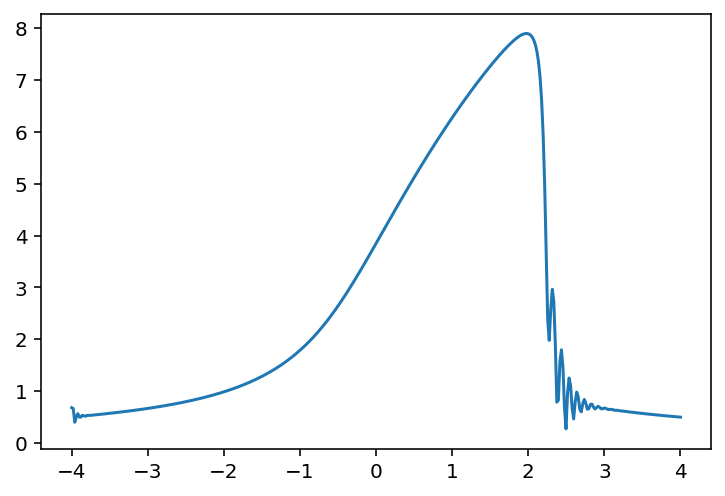

In [7]:
zs,ts,omegas = solve_duffing( 0.0+0.01j, omega0=0.0, omega_start=-4.0, 
                    omega_stop=+4.0, gamma=.5, 
                      epsilon=0.03, force=2.0, 
                      t_end=200.0, nsteps=400 )

plt.plot(omegas,jnp.abs(zs))
plt.show()

Next, we would like to do the same, but for a variety of different force strengths. We use the ```solve_duffing_force_batch``` that was defined above, to do this without a for loop. Note that to use this batched function properly, we cannot name the arguments any more (unlike above):

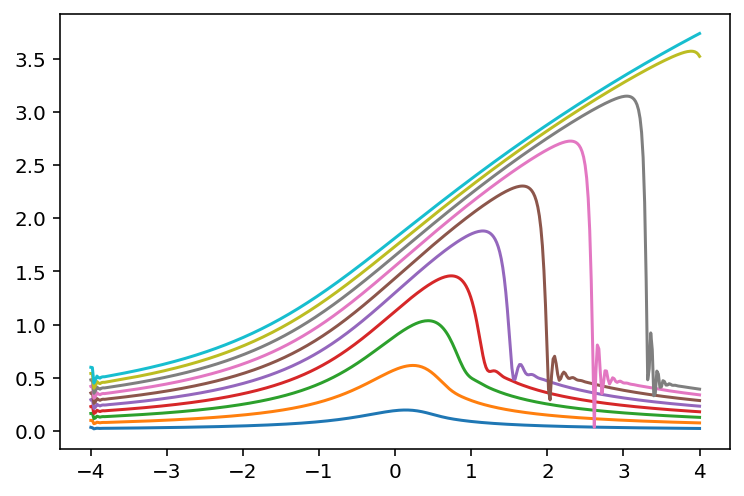

In [8]:
zs,ts,omegas = solve_duffing_force_batch( 0.0+0.01j, 0.0,
                                     1.0, 
                      0.3, jnp.linspace(0.1,2.0,10), 
                     -4.0, +4.0,
                      200.0, 400 )

for j in range(10):
    plt.plot(omegas[j],jnp.abs(zs[j]))
plt.show()

### Train a neural network to predict the parameters by looking at one response curve

#### Producing the training samples

In all slightly more advanced machine learning applications, some of the main effort goes into producing the training samples. Sometimes they are obtained from experiments, sometimes collected from the internet. In our case, we produce them via simulations, using the solver we built above. We thus have to set up a function that will produce a batch of response curves for a set of randomly chosen parameter values.

We now define a little helper routine that produces a training batch of response curves for randomly chosen resonance frequency (omega0), nonlinearity (epsilon), and damping (gamma).

In [14]:
def random_parameter_vectors( key, batchsize , ranges ):
    """
    Produce several vectors of length batchsize, with values randomly
    uniformly distributed within the respective values range [min_val,max_val].
    ranges is a list of such value ranges.
    
    Returns: list of random vectors.
    """
    subkeys = jax.random.split( key, len(ranges) )
    return [ jax.random.uniform( subkey, [ batchsize ], 
                                      minval = value_range[0], maxval = value_range[1] )
            for subkey, value_range in zip(subkeys, ranges) ]

def duffing_produce_training_batch( key, batchsize, ranges , num_frequency_bins,
                                  force=1.0, omega_start=-4.0, omega_end=+4.0,
                                  t_end=200.0, n_steps=400):
    """
    Produce a Duffing model training batch.
    Random values for omega0, gamma, and epsilon are generated uniformly
    in the ranges given in the list 'ranges' (a list of [min_val,max_val] entries).
    
    Returns:
    x, y_target
    
    where
    
    x is of shape [batchsize, num_frequency_bins] and represents the response curves
    y_target is of shape [batchsize, 3] and gives (omega0,gamma,epsilon) for each sample
    """
    omega0s, gammas, epsilons = random_parameter_vectors( key, batchsize, ranges )
    zs,_,_ = solve_duffing_parameter_batch( 0.0+0.0j, omega0s, gammas, epsilons, 
                                 force, omega_start, omega_end, t_end, n_steps )
    x = jax.image.resize( jnp.abs(zs), [ batchsize, num_frequency_bins ] , "linear")
    return x, jnp.stack([omega0s,gammas,epsilons],1)
     
    

Let us illustrate the variety of response curves one gets in a batch:

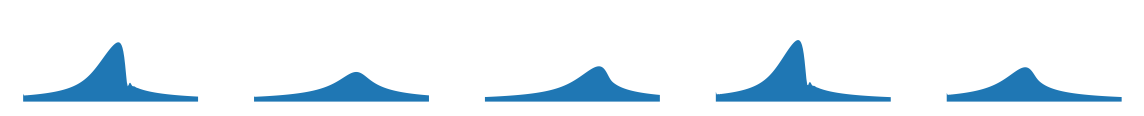

In [15]:
key = jax.random.key( 44 )
num_panels = 5
npixels = 200

x, y_target = duffing_produce_training_batch( key, num_panels, 
                                             [[-1.,1.],[0.5,1.5],[0.0,0.15]], npixels)

omegas = jnp.linspace(-4.,4.,npixels)
fig,ax=plt.subplots(ncols = num_panels, sharey = True, figsize=(10,2))
for idx in range(num_panels):
    ax[idx].fill_between(omegas,0*omegas,x[idx,:])
    ax[idx].set_ylim(0.,4.)
    ax[idx].set_aspect(1.0)
    ax[idx].axis('off')
    omega0,gamma,epsilon=y_target[idx,:]
plt.show()

#### Defining the neural network

We define the same  standard multilayer perceptron (fully connected network) that we used in the previous chapter.

In [18]:
def NN_MLP_with_tanh(x, params):
    """
    Standard MLP with params['weights'] and params['biases'],
    applied to input vector x. Activation tanh applied to all
    layers except last.
    """
    num_layers=len(params['weights'])
    for layer_idx, (weights, biases) in enumerate(zip(params['weights'],params['biases'])):
        x = jnp.matmul(weights,x) + biases
        if layer_idx < num_layers-1:
            x = jnp.tanh( x )
    return x

# produce a batched version (where x has a batch dimension 0)
NN_MLP_with_tanh_batch = vmap(NN_MLP_with_tanh, in_axes=[0,None], out_axes=0)

# batch-averaged mean-square-error deviation between x and y_target:
def mse_loss_batch(x, y_target, params):
    return jnp.sum( ( NN_MLP_with_tanh_batch(x,params) - y_target )**2 ) / jnp.shape(x)[0]

# take gradient with respect to params (argument number '2' out of 0,1,2)
# also return value of loss. Apply jit to compile it:
mse_loss_batch_val_grad = jax.jit( value_and_grad(mse_loss_batch, argnums=2) )

#### Initializing parameters

Let us initialize the neural network parameters and prepare the optax optimizer.

In [19]:
num_frequency_bins = 50 # will be input dimension
num_physics_parameters = 3 # output dimension
learning_rate = 1e-3

key = jax.random.key( 42 )

subkey, key = jax.random.split(key)
params = NN_init_params( subkey, [num_frequency_bins, 100, num_physics_parameters] )

optimizer = optax.adam( learning_rate )
opt_state = optimizer.init( params )

We also prepare some parameters for the training loop.

In [20]:
# training parameters
num_training_batches = 100
batchsize = 32
value_ranges = [[-1.,1.],[0.5,1.5],[0.0,0.15]] # omega0, gamma, epsilon
losses=[]


#### Training

Now we can run the training loop! As usual, in each iteration we produce a training batch, evaluate the network on this batch, get the gradients of the loss function with respect to the neural network parameters, and finally update the parameters

Note: If you want a nice progress bar during training, insert ```from tqdm import tqdm``` at the top of the cell and then use ```tqdm(range(...))``` instead of ```range```.

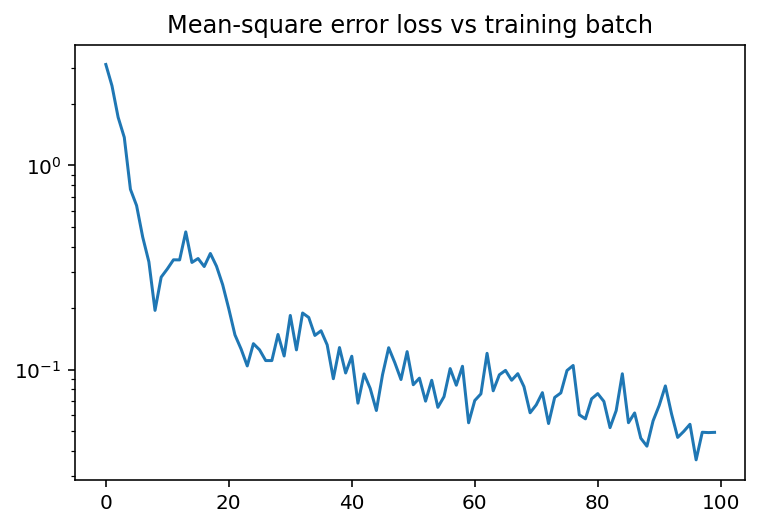

In [21]:
# run this cell multiple times to continue training!

for idx_batch in range(num_training_batches):
    # get training batch:
    subkey,key = jax.random.split( key )
    x, y_target = duffing_produce_training_batch( subkey, batchsize, 
                                                 value_ranges, num_frequency_bins)
        
    # get loss and its gradient with respect to network parameters:
    loss, grads = mse_loss_batch_val_grad( x, y_target, params )

    # update the network parameters:
    updates, opt_state = optimizer.update( grads, opt_state)
    params = optax.apply_updates( params, updates )

    # add the loss to the list:
    losses.append(loss)

plt.plot( losses )
plt.yscale( "log" )
plt.title("Mean-square error loss vs training batch")
plt.show()

Now let us test how well the neural network actually performs. Run it on a random training batch (now of larger batchsize). Then plot the network's predictions for the parameters vs the true parameter values, which are known in the training batch.

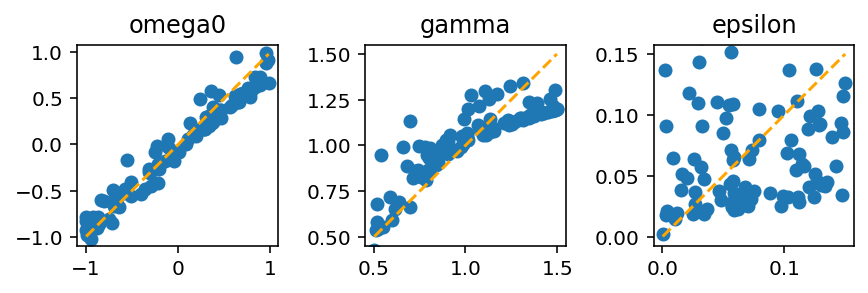

In [22]:
subkey,key = jax.random.split( key )
x, y_target = duffing_produce_training_batch( subkey, 100, 
                                             value_ranges, num_frequency_bins)
y = NN_MLP_with_tanh_batch(x,params)

fig,ax = plt.subplots(ncols=3)
for idx, label in enumerate(["omega0","gamma","epsilon"]):
    ax[idx].scatter(y_target[:,idx],y[:,idx])
    min_max_values=[jnp.min(y_target[:,idx]),jnp.max(y_target[:,idx])]
    ax[idx].plot(min_max_values,min_max_values,"--",color="orange")
    ax[idx].set_ylim(ax[idx].get_xlim())
    ax[idx].set_title(label)
    ax[idx].set_aspect(1.0)
fig.tight_layout()

Ideally, all the dots should lie on the orange line, indicating that the network prediction (vertical) is identical to the true value (horizontal). Apparently, it is most difficult for the network to make good predictions for the nonlinearity strength ```epsilon```.

```{admonition} Exercise
Run the training loop above several times (or set the num_training_batches to a higher value and then run it). After each run, observe that the network performs better!
```

```{admonition} Exercise
Add noise to the training samples, by writing a new training_batch function that calls the old one and adds noise. Use jax.random.normal. Make sure not to forget to split the random key, as shown already in the training loop! Observe how the network can learn in spite of the noise. Also, plot a few of the noisy response curves.
```

### The danger of overfitting: Training on only a few samples

So far, we have had abundant training data: Each sample was freshly simulated, with new randomly chosen parameters. However, if data come from experiments instead of simulations, one often only has a limited amount of training samples. Then, a new and dangerous phenomenon can occur.

Let us mimick the experimental situation by producing a fixed number of samples from our simulation:

In [45]:
num_training_samples = 64
train_x, train_y_target = duffing_produce_training_batch( subkey, num_training_samples, 
                                             value_ranges, num_frequency_bins)


This is now all the data we have to work with. In order to deal with that situation in training, one proceeds in the following standard fashion. In each "epoch" of training, one goes through all the samples in the training data set, in a random order. This can be achieved by setting up a random permutation of all indices of the training samples:

```python
epoch_indices = jax.random.choice(subkey,jnp.arange(num_training_samples), 
    (num_training_samples,), replace=False)
```

We then subdivide this into batches and perform one training step on each batch, like before. As soon as all the training data has been seen once by the neural network in this fashion, one starts the next epoch.

Set up the usual initialization, like before...

In [52]:
num_frequency_bins = 50 # will be input dimension
num_physics_parameters = 3 # output dimension
learning_rate = 1e-3

key = jax.random.key( 42 )

subkey, key = jax.random.split(key)
params = NN_init_params( subkey, [num_frequency_bins, 100, num_physics_parameters] )

optimizer = optax.adam( learning_rate )
opt_state = optimizer.init( params )

# training parameters
num_training_epochs = 1000
batchsize = 16
num_batches_per_epoch = num_training_samples//batchsize

value_ranges = [[-1.,1.],[0.5,1.5],[0.0,0.15]] # omega0, gamma, epsilon
losses=[]


Now run the training loop, with this subdivision into epochs, each of which runs through all the batches of the fixed training data set:

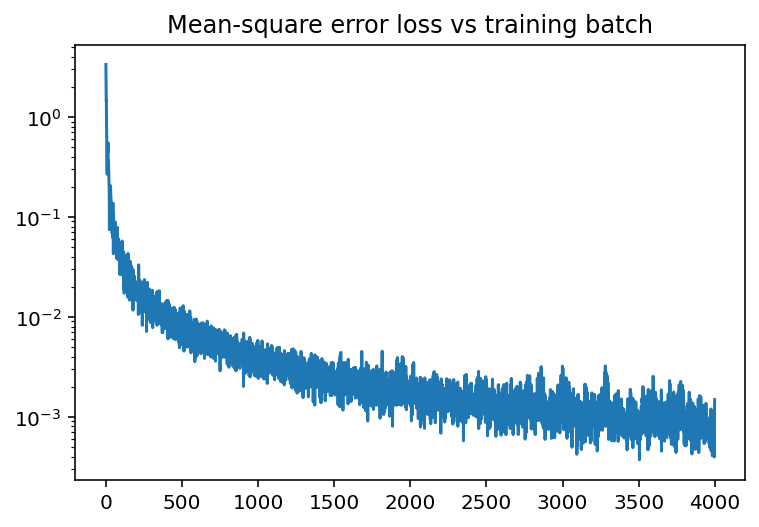

In [53]:
# run this cell multiple times to continue training!

for idx_epoch in range(num_training_epochs):
    # get a random permutation of sample indices:
    subkey,key = jax.random.split( key )
    epoch_indices = jax.random.choice(subkey, 
                        jnp.arange(num_training_samples), 
                        (num_training_samples,), replace=False)

    for idx_batch in range(num_batches_per_epoch):
        # get training batch:
        indices_batch = epoch_indices[idx_batch*batchsize:(idx_batch+1)*batchsize]
        x, y_target = train_x[indices_batch], train_y_target[indices_batch]

        # get loss and its gradient with respect to network parameters:
        loss, grads = mse_loss_batch_val_grad( x, y_target, params )

        # update the network parameters:
        updates, opt_state = optimizer.update( grads, opt_state)
        params = optax.apply_updates( params, updates )

        # add the loss to the list:
        losses.append(loss)

plt.plot( losses )
plt.yscale( "log" )
plt.title("Mean-square error loss vs training batch")
plt.show()



Let us now check how well the network performs. We will now actually test the performance twice: once on the existing training data set, and once on an independent, freshly drawn set of samples. Let us see what happens!

Evaluation on training data set


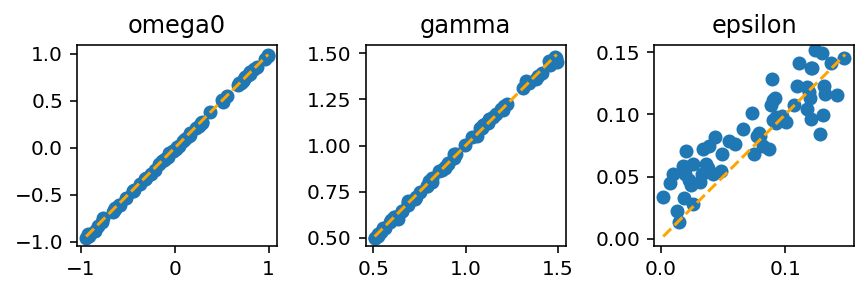

Evaluation on fresh data set


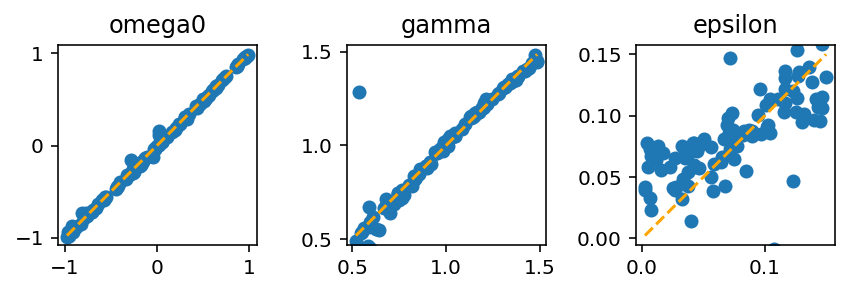

In [54]:
for idx_figure in range(2):
    if idx_figure==0:
        x, y_target = train_x, train_y_target
        print("Evaluation on training data set")
    else:
        subkey,key = jax.random.split( key )
        x, y_target = duffing_produce_training_batch( subkey, 100, 
                                                 value_ranges, num_frequency_bins)
        print("Evaluation on fresh data set")

    y = NN_MLP_with_tanh_batch(x,params)
        
    fig,ax = plt.subplots(ncols=3)
    for idx, label in enumerate(["omega0","gamma","epsilon"]):
        ax[idx].scatter(y_target[:,idx],y[:,idx])
        min_max_values=[jnp.min(y_target[:,idx]),jnp.max(y_target[:,idx])]
        ax[idx].plot(min_max_values,min_max_values,"--",color="orange")
        ax[idx].set_ylim(ax[idx].get_xlim())
        ax[idx].set_title(label)
        ax[idx].set_aspect(1.0)
    fig.tight_layout()
    plt.show()


You can already see that the performance on the existing training set is quite a bit better than on the freshly drawn set. This effect increases with increasing training time (try it!). This is actually bad news! It means that the network does not generalize its performance well. In fact, it has started to "overfit" (or memorize) the samples of the training set, instead of understanding the general structure of the problem. This problem of "overfitting" can be severe. The solution is to always to keep a small piece of the existing data separate from the training data, as a so-called "validation" data set, and to check the network's performance there. This is the performance that counts, since it will not be affected by overfitting. Of course, overfitting only exists as a problem in situations where we train repeatedly on the same data (because data is scarce), instead of producing fresh data for every batch.

Training should be stopped when the performance on the validation data set does not improve anymore (it will actually decrease again when the network starts to overfit). This is called "early stopping". Another technique to avoid overfitting is to inject noise into the network activations during training, which prevents the network from adjusting too much to the details of the training data set. This is called "dropout" (because in some versions, one simply randomly drops some activations, setting them to zero).

Experts go even one step further, holding out some test data that is never looked at during training (not even for evaluating the performance, i.e. not even in the way the validation set is used).

### Train a neural network to predict the parameters by looking at a 2D image of several response curves with a sweep of the force

This is still to be completed (work in progress). It will showcase the use of convolutional neural networks.

In [179]:
zs,ts,omegas = solve_duffing_force_batch( 0.0+0.01j, 0.0, 1.0, 
                      0.3, jnp.linspace(0.1,1.0,100), -4.0, 
                    +4.0,
                      200.0, 400 )


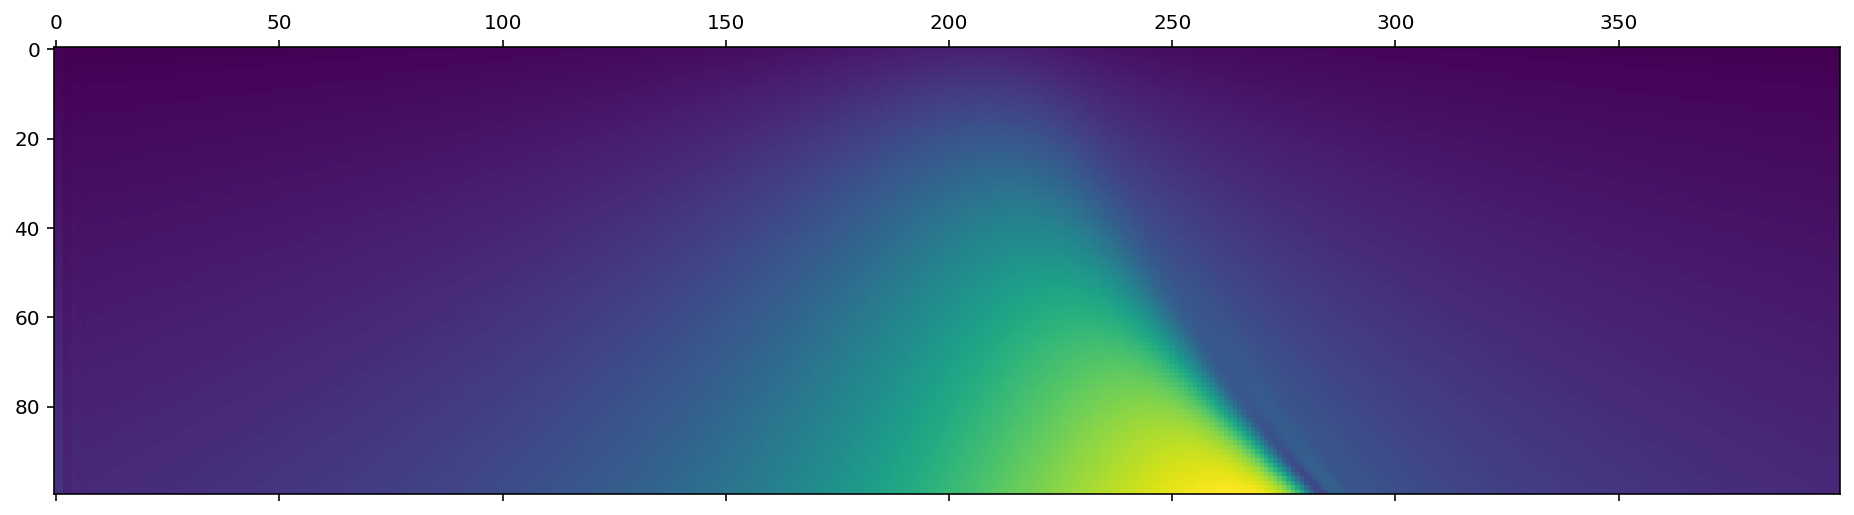

In [180]:
plt.matshow( jnp.abs(zs) )
plt.show()

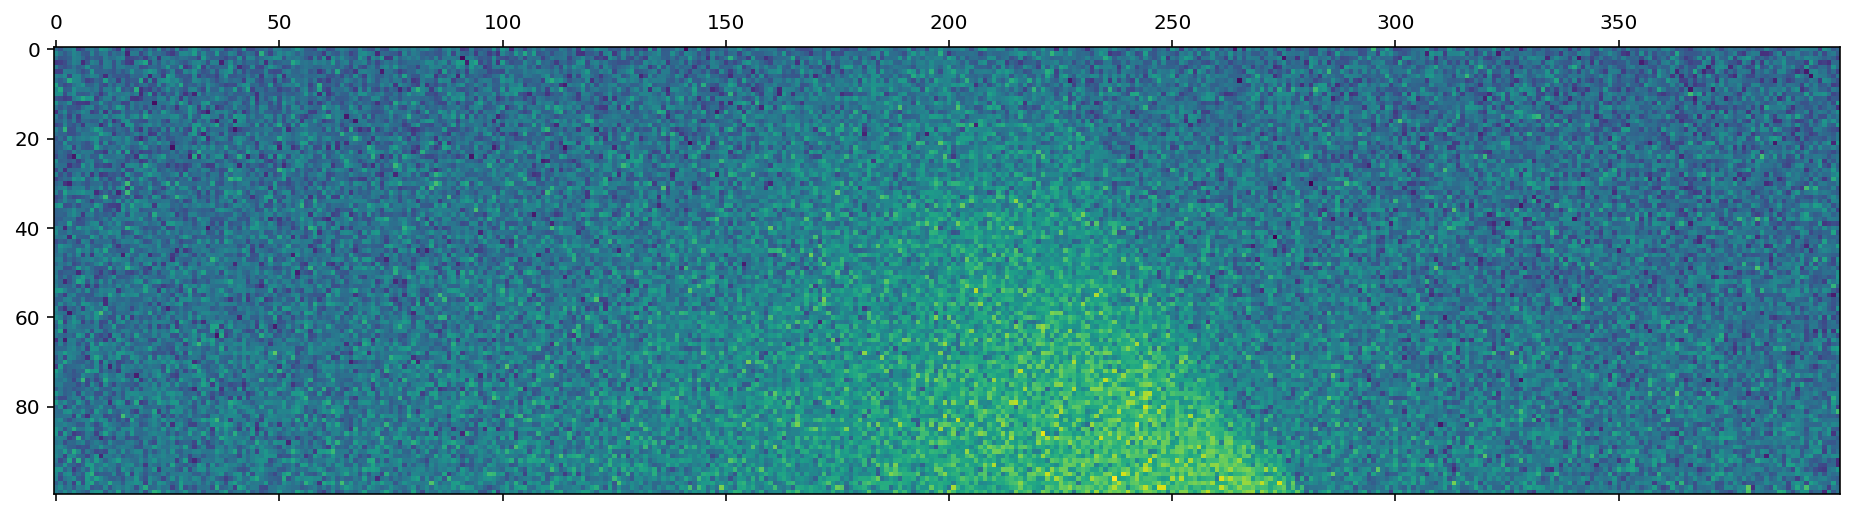

In [181]:
key = jax.random.key(42)
noise = jax.random.normal(key,zs.shape)

plt.matshow( jnp.abs(zs) + 0.5*noise)
plt.show()

In [182]:
zsnew = jax.image.resize(zs, (50,50), "cubic")

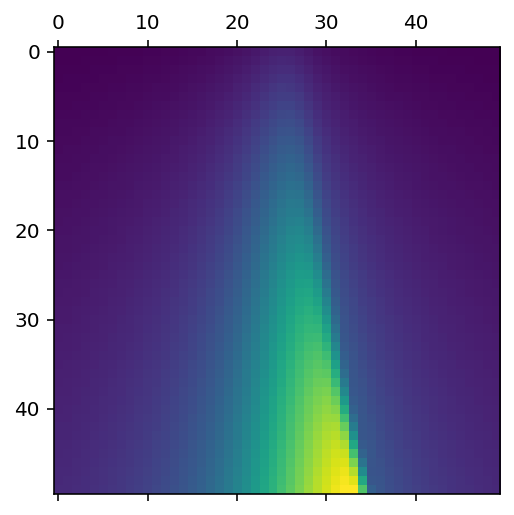

In [183]:
plt.matshow( jnp.abs(zsnew) )
plt.show()